# Before you start: Install Tensorflow and Keras

This assignment requires to install Keras. Using Anaconda, this should be simple:

`conda install keras`

That's it. If you get any conda package conflits, it may be convenient to create a new conda environment:

`conda create -n tf2 tensorflow=2.3.0 jupyter python=3.7 matplotlib seaborn scikit-learn`

This will create a conda environment with the name `tf2` and install tensorflow 2 (including Keras), jupyter notebook, matplotlib, seaborn and python 3.7. You can switch to the newly created `tf2` environment by typing

`source activate tf2` 

And then run

`jupyter notebook`

in the same terminal to open a jupyter notebook. 

_Note that after performing the install, you need to restart this notebook for the changes to take effect._

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)
print(keras.__version__)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Keras imports
from tensorflow.keras import backend as K
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D

2.7.0
2.7.0


In [2]:
def prepare_data(use_classes = [0,8], return_shape_y='matrix',return_shape_x='flat',n_trainex_per_class='all'):
    '''Wrapper function that returns preprocessed training and validation data from the famous MNIST data set
    
    Note: Class labels are _always_ re-assigned such that the class labels returned are in range 0:n_classes 
    (i.e. if you request classes 2 and 8, you will still get labels 0 and 1 out)
    
    input arguments:
        use_classes: list of integers (values from 0-9 in any order)
        Only examples from the classes in this list will be returned
        
        return_shape_y: string ('matrix' or 'vector')
        'matrix' will return a one-hot class encoding of the labels with shape (n_examples x n_classes)
        'vector' will return a list of labels with length (n_examples)
        
        return_shape_x: string ('flat', 'channels' or 'image')
        'flat' will return input images as flattened arrays (n_examples x n_pixels)
        'image' will return input images as stacked images (n_examples x n_rows x n_columns)
        'channels' will return input images as stacked images with an additional channel dimension that tensorflow requires for convolutions
        shape for 'channels' will be either (n_examples x n_rows x n_columns x 1) or (n_examples x 1 x n_rows x n_columns), depending on your keras system settings
        
        n_trainex_per_class: int (values up to 5421 will work (5421 = number of example in smallest class))
        
        
    returns:
        (x_train, y_train): tuple of arrays
            x_train: training set images with shape defined by return_shape_x
            y_train: training set labels with shape defined by return_shape_y
        
        (x_test, y_test): tuple of arrays
            x_test: test set images with shape defined by return_shape_x
            y_test: test set labels with shape defined by return_shape_y
        
        num_classes: int
            number of classes used
        '''
    
    
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # input image dimensions
    img_rows, img_cols = 28, 28

    # find and use only examples of chosen classes
    train_idx = np.isin(y_train,use_classes)
    test_idx = np.isin(y_test,use_classes)
    x_train = x_train[train_idx,:,:]
    y_train = y_train[train_idx]
    x_test = x_test[test_idx,:,:]
    y_test = y_test[test_idx]
    
    # if required, use fewer training examples per class
    if not n_trainex_per_class=='all':
        y_smaller = []
        x_smaller = []
        for c in use_classes:
            class_idx = np.where(y_train==c)[0][:n_trainex_per_class]
            y_smaller.append(y_train[class_idx])
            x_smaller.append(x_train[class_idx,:,:])
        y_train = np.concatenate(y_smaller)
        x_train = np.concatenate(x_smaller)

    # make new class labels that are 0:n_classes (needed for later use of 'keras.utils.to_categorical')
    new_class_ids_mapping = {old_id:new_id for new_id,old_id in enumerate(use_classes)}
    num_classes = len(use_classes)
    y_test = np.array([new_class_ids_mapping[y] for y in y_test])
    y_train = np.array([new_class_ids_mapping[y] for y in y_train])

    # normalize images and print shape
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    # if requested convert class vectors to binary class matrices
    if return_shape_y=='matrix':
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)
    # otherwise return as vector
    elif return_shape_y=='vector':
        pass
    else:        
        raise Exception('unknown return_shape_y')
    
    if return_shape_x=='flat':
        # flatten image data
        x_train = x_train.reshape(len(y_train), img_rows*img_cols)
        x_test = x_test.reshape(len(y_test), img_rows*img_cols)

    elif return_shape_x =='channels':
        # reshape to add channel dimension (being aware of the keras system setting)
        if K.image_data_format() == 'channels_first':
            x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
            x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
            x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)
    elif return_shape_x == 'image':
        pass
    
    else:
        raise Exception('unknown return_shape_x')

    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('x_train shape:', x_train.shape)
    print('y_train shape:', y_train.shape)
        
    return (x_train, y_train), (x_test, y_test), num_classes

# Task 0: Explore the dataset

We load the full MNIST dataset as provided by `tensorflow.keras.datasets.mnist` and plot 10 examples of each class in a 10x10 plot. 

In [3]:
# load data
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes=list(range(10)),return_shape_y='vector',return_shape_x='image',n_trainex_per_class=10)

100 train samples
10000 test samples
x_train shape: (100, 28, 28)
y_train shape: (100,)


In [4]:
# for later use
n_rows = x_train.shape[1]
n_clms = x_train.shape[2]

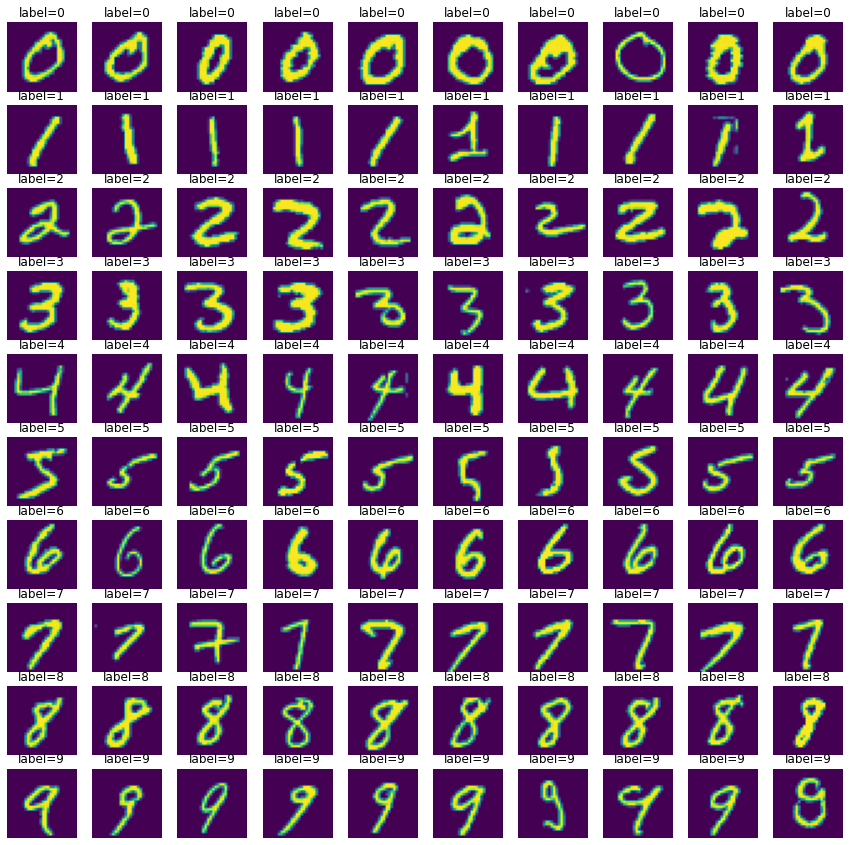

In [5]:
# display the first few examples
fig,axes = plt.subplots(10,10,figsize=(15,15))
axes=axes.flatten()
for i,ax in enumerate(axes):
    
    ax.imshow(x_train[i,:,:])
    ax.set_title('label=%u' % (y_train[i]))
    sns.despine()
    ax.axis('off')
plt.show()

# Task 1: LDA (15 points)

For the rest of the notebook, we will restrict ourselves to the classes `3` and `8`, and also to a subset of examples (`500` per class).

First, use Linear Discriminant Analysis to separate the classes. Here you will need to find a weight vector $\vec{w}$ so that the classes are optimally separated in the projections $p_i =   \vec{w}^T \vec{x}_i$ of data points $\vec{x}_i$.

In [6]:
classes = [3,8]
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes = classes,return_shape_y='vector',return_shape_x='flat',n_trainex_per_class=500)

1000 train samples
1984 test samples
x_train shape: (1000, 784)
y_train shape: (1000,)


Use the analytic solution to compute the optimal weights $\vec{w}$ from the training set data. 

Note: In cases like ours where $n_{features}$ isn't much smaller than $n_{samples}$, the within-class covariance matrix is not invertible. To fix this, we can add a small constant to the diagonal of it, which is equivalent to ridge regularization. Play a bit with the value of the pentaly to see its effect and find a value that gives good results.

You can rely on the fact that there is the same number of samples in each class (it simplifies some of the formulas).

In [7]:
def compute_lda_weights(x,y,alpha=1):
    '''function that computes regularized LDA weights for a two class problem
    
    input:
        x: training data -- array with shape (n_examples x n_features)
        y: training data class label -- flat array with length (n_examples)
        alpha: regularization strength -- float
        
    returns:
        m0: mean of the training examples of class 0 -- flat array with length (n_features)
        m1: mean of the training examples of class 1 -- flat array with length (n_features)
        mdiff: difference of the two class means -- flat array with length (n_features)
        w: regularized LDA weight vector -- flat array with length (n_features)
        '''
    
    # covariances per class
    cov0 = np.cov(x[y==0,:],rowvar=False)  
    cov1 = np.cov(x[y==1,:],rowvar=False)
    # means per class
    m0 = np.mean(x[y==0,:],axis=0)
    m1 = np.mean(x[y==1,:],axis=0)
    mdiff = m1-m0
    
    # invert within-class covariance matrix
    # add small constant variance to diagonal
    const = np.eye(n_rows*n_clms)*alpha
    S_within = cov0+cov1+const
    S_within_inv = np.linalg.inv(S_within)

    # get optimal projection vector w
    w = S_within_inv @ mdiff
    
    return m0,m1,mdiff,w

As  $\vec{w}$ has the dimensionality of our input data, we can interpret it as image with the same size as the training examples. Reshape the weight vector accordingly and plot the resulting 'weight image'. Describe and interpret the image.

In [8]:
def plot_weight_image(flat_data,im_dim,titlestr):
    '''Function that takes a flat vector with the same dimensionality as the input data 
    and plot it as an image of the shape of the original images'''
    
    # INSERT YOUR CODE HERE
    w_matrix = np.reshape(flat_data,im_dim)
    ax = plt.imshow(w_matrix)
    plt.title(titlestr)
    return ax
    


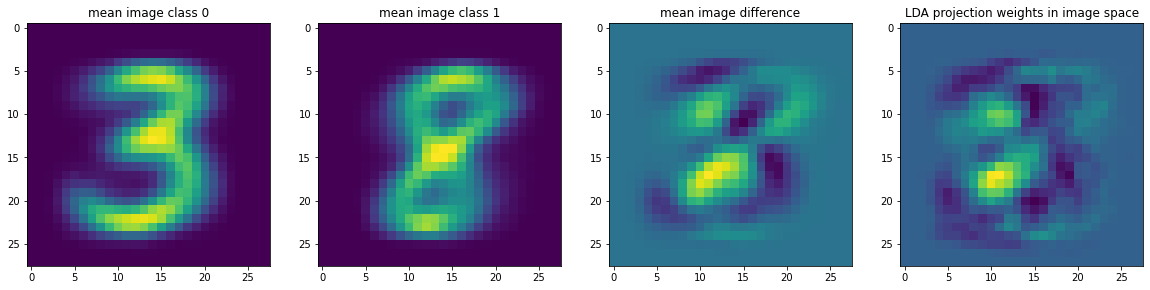

In [9]:
# compute weights
m0,m1,mdiff,w = compute_lda_weights(x_train,y_train,alpha=1)

# vizualize input data and resulting weight vector
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plot_weight_image(m0,(n_rows,n_clms),'mean image class 0')
plt.subplot(1,4,2)
plot_weight_image(m1,(n_rows,n_clms),'mean image class 1')
plt.subplot(1,4,3)
plot_weight_image(mdiff,(n_rows,n_clms),'mean image difference')
plt.subplot(1,4,4)
plot_weight_image(w,(n_rows,n_clms),'LDA projection weights in image space')
plt.show()

## Question

As  $\vec{w}$ has the dimensionality of our input data, we can interpret it as image with the same size as the training examples. Reshape the weight vector accordingly and plot the resulting 'weight image'. Describe and interpret the image.

## Answer:

* The 'weight image' depicts which inputs (in this case pixels) contribute the most to predicting each class. 

* The "mean image difference" image shows which inputs contribute most to each class. In this case pixel selected where the weighting is negative (dark), would contribute to predicting a 3, and the light sections an 8. 
    * The very light section of the bottom left side of the "8", is easy to understand, in that if a pixel in this area is coloured in, the number is almost certainly an 8.

    * The dark blue areas in the mean image difference are slightly more difficult to interpret (but only slightly). Despite having similar shapes, the path taken when handwriting a 3, tends more toward the right (on average) than when drawing an 8. As such, if these far-right (not-politically) pixels/weights are selected, the likelihood that the number is 3 is higher than that for an 8.

* The LDA projection weights are a corrected/altered version of the "mean image difference", following the same logic. The weights here have been determined to be optimal for classifying a 3/8.

---

Project the training data and the test data on $\vec{w}$. Visualize the class separation using a two-color histogram. Is the separation good? Is there a big difference between training and test data?

In [10]:
# Compute the projections for training and test data

# INSERT YOUR CODE HERE 
x_train_proj = x_train @ w
x_test_proj = x_test @ w
print(x_test.shape)
print(x_test_proj.shape)

(1984, 784)
(1984,)


In [11]:
def projection_histogram(x_proj,y,titlestr='',threshold='none'):
    '''Function that projects data x on a LDA weight vector w and plots the projection values separately by class
    
        input:
        x_proj: input data -- flat array with length (n_examples)
        y: class labels -- flat array with length (n_examples)
        titlestr: histogram title string
        threshold: threshold value (float) or 'none' (string) to not plot a threshold
    '''

    # INSERT YOUR CODE HERE
    
    sns.histplot(x=x_proj,hue=y)
    plt.title(titlestr,size=20)
    plt.ylabel("Frequency")
    plt.xlabel("Class Prediction aka Weight x Input")
    
    
    if threshold != 'none':
        plt.axvline(threshold)
        plt.text(x=threshold,y=5,s="Threshold")

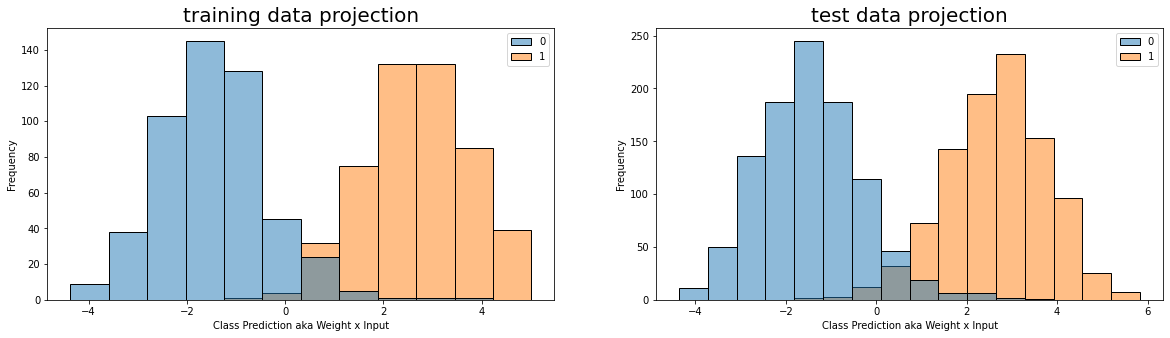

In [12]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
projection_histogram(x_train_proj,y_train,'training data projection')
plt.subplot(1,2,2)
projection_histogram(x_test_proj,y_test,'test data projection')
plt.show()

## Question
Project the training data and the test data on $\vec{w}$. Visualize the class separation using a two-color histogram. Is the separation good? Is there a big difference between training and test data?

## Answer
* Separation on training data is pretty good, with only minimal overlap
* Negative values tend to predict class 0, and positive values generally class 1.
* Difference between test and training sets is pretty minimal. Test set does have a larger spread for class 1, than in the training data.
---

Now we make class predictions based on the projections. Compute the threshold $c$ for projected values $p_i$ based on the training data (assigning each point to the class with higher posterior probability; assuming balanced classes, that's the same as higher likelihood). Print the value of $c$ and plot $c$ into the histograms of projected values you made before. You can use the fact that the classes are balanced.

Use $c$ to assign class labels for training and test set. Determine the classification errors on both datasets and print them. 

In [13]:
def opt_c_LDA(m0,m1,w):
    '''Compute the optimal threshold for LDA 
    
    input:
        m0, m1: mean vectors of the two classes -- flat array with length (n_features)
        w: weight vector of LDA -- flat array with length (n_features)
        
    output:
        c: the optimal threshold for LDA
         
    '''
    
    # INSERT YOUR CODE HERE
    # From wikipedia c = w * .5 (m1 + m0)
    c = w.T@(0.5*(m1+m0))
    return c

In [14]:
def score_LDA(x_proj,y,c):
    '''Compute the optimal threshold for LDA and the return the error 
    based on thresholding projected values
    
    input:
        x_proj: projected data -- flat array with length (n_examples)    
        y: class labels -- flat array with length (n_examples)
        c: optimal threshold for LDA - scalar
        
    output:
        y_hat: class label predicitons of LDA model -- flat array with length (n_examples)
        error: classification error
        
    '''
    
    # INSERT YOUR CODE HERE
    
    y_hat = x_proj > c
    diff = y-y_hat
    error = diff.T@diff/len(y)
    
    return y_hat, error

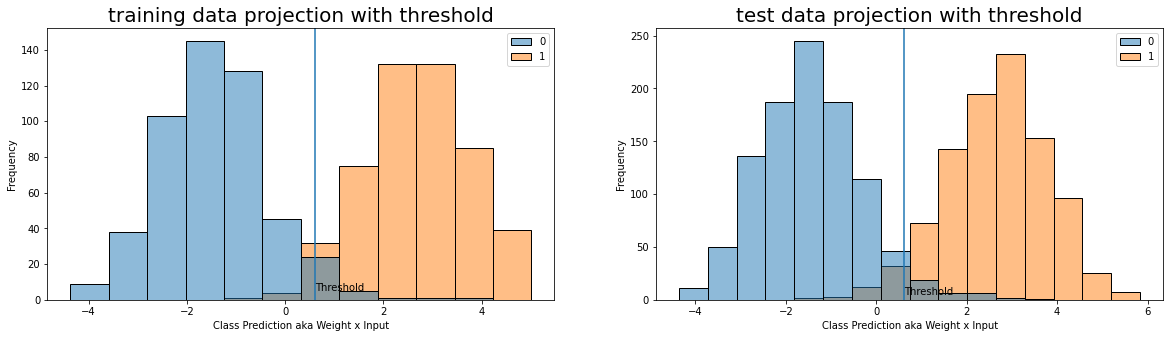

Training set error (LDA):  0.034
Test set error (LDA):      0.04032258064516129


In [15]:
c = opt_c_LDA(m0,m1,w)

y_hat_train, error_train = score_LDA(x_train_proj,y_train,c)
y_hat_test, error_test = score_LDA(x_test_proj,y_test,c)

# show threshold in histograms
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
projection_histogram(x_train_proj,y_train,'training data projection with threshold',c)
plt.subplot(1,2,2)
projection_histogram(x_test_proj,y_test,'test data projection with threshold',c)
plt.show()

# print training and test set accuracy
print("Training set error (LDA): ", error_train)
print("Test set error (LDA):     ", error_test)

## Task 2: MNIST with Logistic Regression (15 points)

Now we will use logistic regression, again using `sklearn`. To make sure results are comparable, set the parameters `random_state=1` and `solver='saga'` when you define the models. Also, if you get convergence warnings choose a larger `max_iter` until all your models converge. You should not need more than 5000 iterations. Use the `n_jobs` parameter to control multiprocessing behavior (this can give a good speed-up for the later parts of this task if you have multiple CPU cores).

### Unregularized logistic regression
First, fit an unregularized logistic regression model using `sklearn`'s `LogisticRegression()`, and use `sklearn`'s in-built scoring function to get a test set error.

In [16]:
# define model
# INSERT YOUR CODE HERE
logreg_base = LogisticRegression(random_state=1, solver='saga', max_iter=5e3)

# fit
# INSERT YOUR CODE HERE
logreg_base.fit(x_train,y_train)
# score
print("Test set error (LogReg - no regularization) :", 1 - logreg_base.score(x_test,y_test))

Test set error (LogReg - no regularization) : 0.0463709677419355


### Ridge and Lasso with CV
Next, we will use Lasso and Ridge regularized logistic regression

Use `sklearn`'s `LogisticRegressionCV()` model to run a 10-fold crossvalidation over ten different log-spaced regularization strengths to find an optimal regularization strength; do this for both Lasso and Ridge regularization. Hint: Watch out for the parametrisation `sklearn` uses to pass the regularization strength. Note that this can take a few minutes to run.

In [17]:
# set shared hyperparameters
n_folds = 10
n_alphas = 10
max_iter = 5000

# define models
# INSERT YOUR CODE HERE

# Note: Could pass own alphas with a finer range around the optimal alpha...
# but as this isn't the goal of this exercise, I haven't.
logreg_lasso_cv = LogisticRegressionCV(penalty='l1',
                                       cv=n_folds,
                                       Cs=n_alphas,
                                       solver='saga',
                                       random_state=1,
                                       max_iter=max_iter,
                                       n_jobs=-1)
logreg_ridge_cv = LogisticRegressionCV(penalty='l2',
                                       cv=n_folds,
                                       Cs=n_alphas,
                                       solver='saga',
                                       random_state=1,
                                       max_iter=max_iter,
                                       n_jobs=-1)


# fit models
# INSERT YOUR CODE HERE
logreg_lasso_cv.fit(x_train,y_train)
logreg_ridge_cv.fit(x_train,y_train)

LogisticRegressionCV(cv=10, max_iter=5000, n_jobs=-1, random_state=1,
                     solver='saga')

Plot crossvalidation curves for both lasso and ridge regularized logisitic regression: Plot regularization strength $\alpha$ vs. accuracy for each fold. Indicate the average accuracy across folds and mark the average score with optimal $\alpha$. In the code below, we already convert the sklearn parametrization of the regularization strength to a standard format.

In [18]:
def plot_cv_curves(alphas, cv_scores,titlestr=""):
    '''Function that plots CV results: data from each fold/alpha combination,
    average over fold and a special mark for the optimal alpha.
    
    inputs: 
        alphas - flat array with alphas used in the CV, length (n_alphas)
        cv_scores - array accuracy values for each score/alpha combination, shape (n_folds x n_alphas)
    '''
    
    # INSERT YOUR CODE HERE
    avg_scores = cv_scores.mean(axis=0)
    plt.plot(alphas,cv_scores.T, c="grey", alpha=0.3,label=None)
    plt.plot(alphas,avg_scores,c="darkred",label="Avg Accuracy")
    plt.xscale("log")
    #plt.text(alphas.min(),cv_scores.min(),f"Mean Accuracy: {avg_scores[np.argmax(avg_scores)].round(5)}\n Opitmal Alpha: {alphas[np.argmax(avg_scores)].round(5)}")
    plt.xlabel("Alpha")
    plt.ylabel("Accuracy")
    plt.title(titlestr)
    
    plt.axvline(alphas[np.argmax(avg_scores)],label=f"Optimal Alpha: {alphas[np.argmax(avg_scores)].round(5)}\nwith mean accuracy: {avg_scores[np.argmax(avg_scores)].round(5)}")
    plt.legend()
    
    # Note to self. 1 /(1+exp(0)) = 0.5. High regularisation results in everything being predicted with 0.5.
    # If classes are balanced, ie 1:1, then a 0.5 prediction will result in 50% accuracy. 
        
        
        


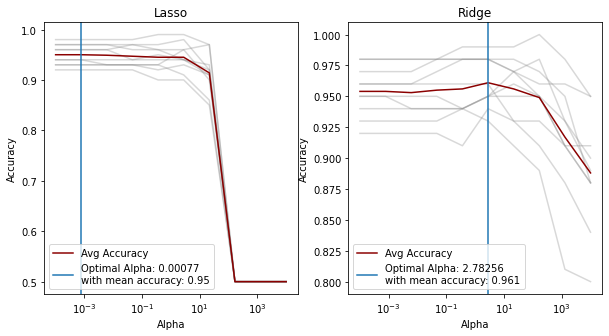

In [19]:
alphas_lasso = 1/logreg_lasso_cv.Cs_
alphas_ridge = 1/logreg_ridge_cv.Cs_
cv_scores_lasso = logreg_lasso_cv.scores_[1]
cv_scores_ridge = logreg_ridge_cv.scores_[1]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_cv_curves(alphas_lasso,cv_scores_lasso,"Lasso")
plt.subplot(1,2,2)
plot_cv_curves(alphas_ridge,cv_scores_ridge,"Ridge")
plt.show()

For both Lasso and Ridge, show how the 'weight images' change as a function of regularization strength. Plot one weight image per regularization strength value. Use `plt.colorbar()` to show the color-value mapping next to each plot so you can also see if the range of values changes. Describe and interpret what you observe.

In [20]:
def plot_weight_image_evolution(alphas,coefs_paths):
    '''function that plots weight image change with alphas'''

    fig,axes=plt.subplots(2,np.ceil(len(alphas)/2).astype(int),figsize=(15,5))

    # INSERT YOUR CODE HERE
    
    
    
    for i, ax in enumerate(axes.flat):
        img = coefs_paths[:,i,:-1].mean(axis=0).reshape(28,28)
        im = ax.imshow(img)
        plt.colorbar(im,ax=ax)
        tstr = f"Alpha: {alphas[i].round(2)}"
        ax.text(2, 4, tstr, fontsize=8,c="white")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

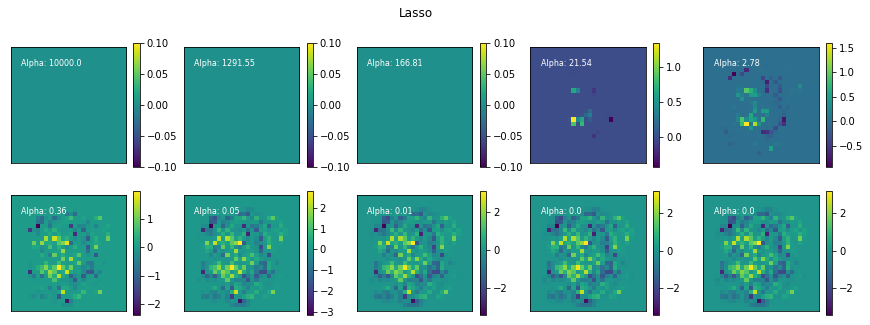

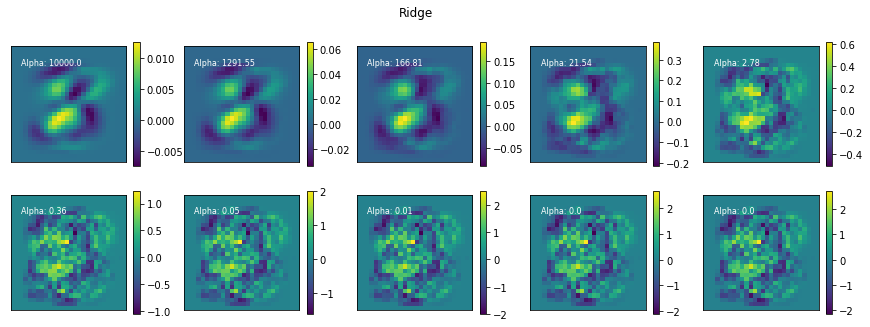

In [21]:
plot_weight_image_evolution(alphas_lasso,logreg_lasso_cv.coefs_paths_[1])
plt.suptitle('Lasso')
plt.show()

plot_weight_image_evolution(alphas_ridge,logreg_ridge_cv.coefs_paths_[1])
plt.suptitle('Ridge')
plt.show()

## Question
For both Lasso and Ridge, show how the 'weight images' change as a function of regularization strength. Plot one weight image per regularization strength value. Use `plt.colorbar()` to show the color-value mapping next to each plot so you can also see if the range of values changes. Describe and interpret what you observe.

## Answer
* Ridge regression allows some values to increase in magnitude, as others decrease. This serves as a way to the model to focus heavily on only those inputs that predict each class.

* Highly regularised LASSO logit does not lend itself to good prediction. As all values will be set to 0, and 1 /(1+exp(0)) = 0.5. High regularisation results in everything being predicted with a value of 0.5. We see this, in that the pixels/plots for LASSO slowly disappear.

* Highly regularised Ridge Logit on the otherhand, while also restricting the weights absolute size, allows for relevent inputs weights to increase. This is why we see little change in the top 3 images for Ridge, although the magnitudes of the weights are decreasing. The regularisation is in essence, depressing irrelevent pixels. 

* Highly regularised Ridge Logit reproduces a weight image very similar to what we see for LDA.

* The magnitude for each plot (value range) decreases with each increased level of regularisation (as is the direct intent behind regularisation).
---

Compare the test error of the best lasso regularized logistic regression, the best ridge regularized logistic regression and the unregularized model.


In [22]:
print("Test set error (LogReg - no regularization) :", 1 - logreg_base.score(x_test,y_test))
print("Test set error (LogReg - ridge) :", 1 - logreg_ridge_cv.score(x_test,y_test))
print("Test set error (LogReg - lasso) :", 1 - logreg_lasso_cv.score(x_test,y_test))

Test set error (LogReg - no regularization) : 0.0463709677419355
Test set error (LogReg - ridge) : 0.03931451612903225
Test set error (LogReg - lasso) : 0.05393145161290325


Plot 'weight images' of the best lasso regularized logistic regression, the best ridge regularized logistic regression and the unregularized model. Describe and interpret the differences you observe. Also compare to the weight image obtained with LDA!

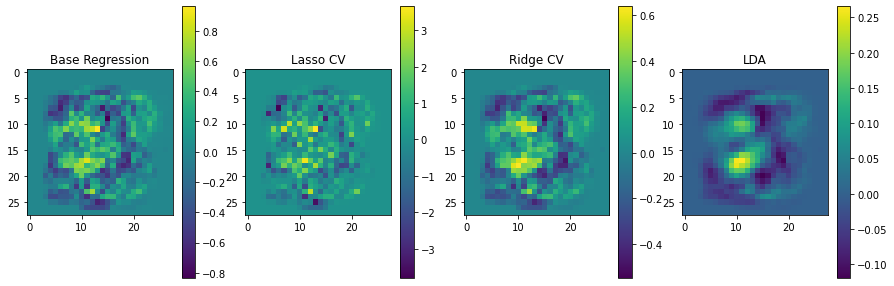

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.title("Base Regression")
plt.imshow(logreg_base.coef_[0].reshape(28,28))
plt.colorbar()
plt.subplot(1,4,2)
plt.title("Lasso CV")
plt.imshow(logreg_lasso_cv.coef_[0].reshape(28,28))
plt.colorbar()
plt.subplot(1,4,3)
plt.title("Ridge CV")
plt.imshow(logreg_ridge_cv.coef_[0].reshape(28,28))
plt.colorbar()
plt.subplot(1,4,4)
plot_weight_image(w,(n_rows,n_clms),'LDA')
plt.colorbar()


plt.show()

## Question
Plot 'weight images' of the best lasso regularized logistic regression, the best ridge regularized logistic regression and the unregularized model. Describe and interpret the differences you observe. Also compare to the weight image obtained with LDA!

## Answer

* Very similar weight images for regressions, when taking into consideration the weight regularisation-transformations plotted above (i.e. nothing has gone horribly wrong/in a different direction).

* The weight scales are drastically different. The scale itself is not relevent for comparison, as long as inputs (pixels) is valued the same with respect to its neighbours the prediction should be the same.

* We saw in earlier steps, that LASSO destroys the ability to effectively find important/influential pixels. This was also shown by Lasso having the worst error. We see again, that the LASSO weight image is the least similar of the 3 methods (poorly defined yellow and dark-blue areas). Base regression and ridge CV have relatively similar images. LASSO also relies heavily on only very few pixels/weights. From conceptual point of view, it doesn't really have a good grasp of what it is doing!

* Ridge CV has the smoothest weight transitions (light to dark) of the 3 regressions. Implying the weights "understand" not just which pixels, but which areas contribute most to each number/class.

* As mentioned above, the Ridge CV is most similar to what we saw with LDA, albeit not as smooth. 

* Overall, each image is at least somewhat similar to what we saw with LDA - Same basic shape. Same basic areas with same basic weights (relative). 
---

## Task 3: MNIST with simple Keras Fully connected neural network  (10 points)

Now we use the Keras library that provides easy access to custom neural network implementation. If you look for a tutorial, try this:

https://keras.io/getting-started/sequential-model-guide/

In the two Keras tasks (Task 3 & 4), your job is to play with the hyperparameters and find an architecture that works and, in the best case, outperforms the more simple models from before that reached about 95% test set performance.

We start with a fully connected network - which is basically a logistic regression, with an added layers of hidden units.

In [43]:
# loading the data in a format suitable for Keras and fully connected networks (flat inputs)
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes = classes,return_shape_x='flat',return_shape_y='matrix',n_trainex_per_class=500)

1000 train samples
1984 test samples
x_train shape: (1000, 784)
y_train shape: (1000, 2)


Create a Keras model with two fully connected layers that takes our (flattened) images as input and outputs a softmax class score for both classes. Use `.summary()` to display the model's structure.

You can experiment with different sizes of the hidden layers, and you can also experiment with adding Dropout layers if you want (this was not covered in the lecture, so is strictly optional).

In [44]:
# hyperparameter
n_hidden_units = 512
# dropout_strength = 0.2

# define model
# INSERT YOUR CODE HERE
model_fcn = keras.Sequential(
    [
        keras.Input(shape=(x_train.shape[1],)),
        Dense(n_hidden_units, activation="relu", name="HiddenLayer", activity_regularizer=keras.regularizers.l2(1e-4)),
        Dense(num_classes, activation="softmax", name="Output"),
    ]
)

# print model structure
y = model_fcn(x_train)
model_fcn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer (Dense)         (None, 512)               401920    
                                                                 
 Output (Dense)              (None, 2)                 1026      
                                                                 
Total params: 402,946
Trainable params: 402,946
Non-trainable params: 0
_________________________________________________________________


Set up the model optimization with `compile()`: use stochastic gradient descent (`SGD()`) with default settings (but you can also try adaptive optimizers, such as `Adam()` if you want). Use a crossentropy loss. Make sure Keras saves the `accuracy` metric for each epoch of the optimization.

Train the network on the training set for 100 epochs, and specify the test set as  `validation_data` in your call to `.fit()`. Make sure you save the output of `.fit()` to a variable.

In [45]:
# hyperparameters
batch_size = 128
epochs = 100



# choose loss and optimzer
# INSERT YOUR CODE HERE
tf.random.set_seed(5)

model_fcn.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
)


# fit model, return training history
# INSERT YOUR CODE HERE
history_fcn = model_fcn.fit(
    x=x_train,
    y=y_train[:,1],
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test,y_test[:,1]),
    verbose=0
)

Report the test set error and loss.

In [46]:
# get final testset evaluation
# INSERT YOUR CODE HERE
score = ( 
    history_fcn.history['val_loss'][-1],
    history_fcn.history['val_accuracy'][-1])

print("Test set error (Dense NN):", 1 - score[1])
print("Test set loss (Dense NN): ", score[0])

Test set error (Dense NN): 0.03326612710952759
Test set loss (Dense NN):  0.1173720508813858


Plot the trajectories of loss and accuracy for both test and training set, using the `history` object that `.fit()` returns. Describe how test and training loss behave over epochs. What do you observe and why?

In [56]:
def plot_history(history):
    '''Takes the history object returned by Keras' ´.fit()´ function and
    plots loss and accuracy curves for both training and validation set '''
    
    # INSERT YOUR CODE HERE
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title("Loss Curves")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    #ax[0].set_ylim([0,1.15])
    ax[0].legend(["Train","Test"])
    
    
    ax[1].set_title("Accuracy Curves")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_ylim([0,1])
    ax[1].legend(["Train","Test"])



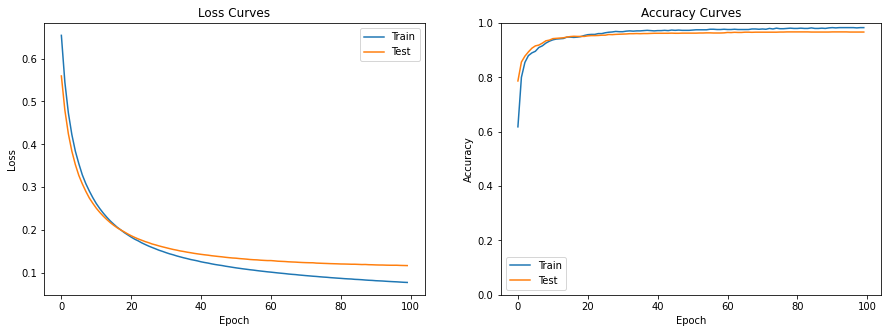

In [57]:
plot_history(history_fcn)

## Question
Plot the trajectories of loss and accuracy for both test and training set, using the `history` object that `.fit()` returns. Describe how test and training loss behave over epochs. What do you observe and why?

## Answer
* The losses of both sets decrease pretty rapidly, followed by much slower decreases. Analogous to real life learning, the overall basics are learned first, followed by fine-tuning. 

* The training loss continues to decrease. The Test loss also continues to decrease, however remains above the loss of the training set. This is pretty standard and to be expected, as the model is built for the training data, with the hope that it translates just as well to the test data.

* Interestingly the Test loss (and accuracy) starts of better than the training loss for early epochs. Unsure if this is to be expected, or merely a result of chance.

---

## Task 4: MNIST with simple Keras CNN  (10 points)

In [49]:
# load the data in a conv net & keras friendly format
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes = classes,return_shape_x='channels',return_shape_y='matrix',n_trainex_per_class=500)

1000 train samples
1984 test samples
x_train shape: (1000, 28, 28, 1)
y_train shape: (1000, 2)


We defined a Keras model with convolutional layers and a fully connected top layer that outputs a softmax class score for both classes. Note that some of the parameters used below (number of hidden neurons, number of features, kernel size, etc) are not very good. Modify the existing network to obtain better results. Use `.summary()` to display the model's structure. Play with the hyperparameters such that you get roughly the same number of parameters as in the fully connected network above.

In [50]:
# hyperparameters
input_shape = x_train.shape[1:]
#Original HPs
#n_features_conv1 = 8 
#n_features_conv2 = 16
#n_features_top = 10 
#kernel_size = 11
#pool_size = 2

n_features_conv1 = 30
n_features_conv2 = 50
n_features_top = 200 
kernel_size = 10
pool_size = 2

#define model
model = Sequential()
model.add(Conv2D(n_features_conv1, kernel_size=(kernel_size, kernel_size),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(n_features_conv2, (kernel_size, kernel_size), activation='relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Flatten())
model.add(Dense(n_features_top, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# show model structure
model.summary()

#Goal: 402,946

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 19, 19, 30)        3030      
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 50)        150050    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 50)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1250)              0         
                                                                 
 dense_2 (Dense)             (None, 200)               250200    
                                                                 
 dense_3 (Dense)             (None, 2)                 402       
                                                      

Configure the optimization as in Task 3 and train for 100 epochs as in Task 3.

In [51]:
batch_size = 128
epochs = 100

# choose loss and optimizer
# INSERT YOUR CODE HERE
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
)


# fit model, return history
# INSERT YOUR CODE HERE
history_cnn = model.fit(
    x=x_train,
    y=y_train[:,1],
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test,y_test[:,1]),
    verbose=0
)

As in Task 3, print test set loss and error and plot the trajectories of loss and accuracy for training and test set. Discuss the differences and similarities to the fully connected model. What is the best model over everything?

Test set error (Conv NN): 0.0075604915618896484
Test set loss (Conv NN):  0.04094253480434418


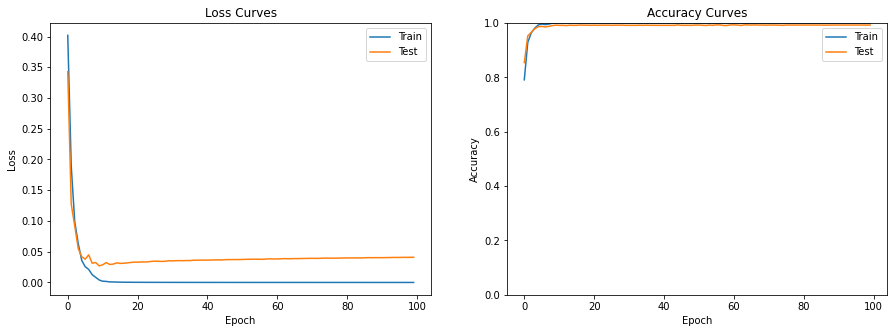

In [58]:
 # INSERT YOUR CODE HERE
score = [0,0]
score[0] = history_cnn.history['val_loss'][-1]
score[1] = history_cnn.history['val_accuracy'][-1]

print("Test set error (Conv NN):", 1 - score[1])
print("Test set loss (Conv NN): ", score[0])

plot_history(history_cnn)

As in Task 3, plot the trajectories of loss and accuracy for training and test set. Discuss the differences and similarities to the fully connected model. What is the best model over everything?

## Question

* As in Task 3, print test set loss and error and plot the trajectories of loss and accuracy for training and test set. Discuss the differences and similarities to the fully connected model. What is the best model over everything?

* As in Task 3, plot the trajectories of loss and accuracy for training and test set. Discuss the differences and similarities to the fully connected model. What is the best model over everything?

## Answer

|Metric|FCN|CNN|
|---|---|---|
|Val_Error|0.0332|0.007|
|Val_Loss| 0.1176|0.041|
|Val_Accuracy| 0.9667|0.9924|

* Val_Error
    * Error is significantly smaller for the CNN. However, both Errors are very very small.
* Val_Loss
    * Losses, as above are both very small, with CNN outperforming the FCN by a lot.
* Val_Accuracy (1-Error)
    * Both perform very well on the data. Both have essentially 100% accuracy, however given the choice, CNN would be prefered.
* Both curves for the CNN are a lot rougher (variate a lot more over epochs) than those for FCN. Unsure what the significance would be.
* The CNN model has roughly the same number of nodes (with the given parameters) as the FCN, but performs better.
* Both NNs reach a relatively stable point after few epochs. Both continue to improve beyond this point, however only minimally. Given the short time to train, this is certainly worth the wait.
* The overall best model would be the CNN.